In [77]:
import os
import sys
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

PROJECT_ROOT = os.path.abspath("..")

if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from matplotlib import pyplot as plt
from src.models.ctr_model import train_ctr_model, predict_click_proba, FEATURE_COLS, TARGET_COL

NBO_DATASET_PATH = os.path.join(PROJECT_ROOT, "data", "processed", "nbo_dataset.csv")
df = pd.read_csv(NBO_DATASET_PATH)

print("Данные загружены")
print(f"Всего рекламных записей: {len(df)}")
print(f"Из них было показано: {(df['treatment']==1).sum()}")
print(f"Кликов по ним: {df['outcome_click'].sum()} или {df['outcome_click'].mean()*100:.1f}%")


Данные загружены
Всего рекламных записей: 15312
Из них было показано: 12323
Кликов по ним: 9825 или 64.2%


Разделяем данные: 80 на обучение и 20 на тест

In [78]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['outcome_click']
)

print(f"Тренировачные: {len(train_df)} записей")
print(f"Тестовые:  {len(test_df)} записей")
print(f"Тренировачные с показом: {(train_df['treatment']==1).sum()}")
print(f"Тестовые с показом: {(test_df['treatment']==1).sum()}")


Тренировачные: 12249 записей
Тестовые:  3063 записей
Тренировачные с показом: 9860
Тестовые с показом: 2463


Обучаем модель

In [79]:
model = train_ctr_model(train_df)

print("Модель обучена и сохранена!")

0:	total: 7.87ms	remaining: 7.86s
100:	total: 146ms	remaining: 1.3s
200:	total: 298ms	remaining: 1.18s
300:	total: 433ms	remaining: 1.01s
400:	total: 573ms	remaining: 855ms
500:	total: 712ms	remaining: 709ms
600:	total: 861ms	remaining: 572ms
700:	total: 1.01s	remaining: 432ms
800:	total: 1.15s	remaining: 286ms
900:	total: 1.29s	remaining: 142ms
999:	total: 1.46s	remaining: 0us
Модель обучена и сохранена!


Тестируем модель на оставшихся записях

In [80]:
test_treatment = test_df[test_df['treatment'] == 1].copy()
X_test = test_treatment[FEATURE_COLS]
y_test = test_treatment[TARGET_COL]

In [81]:
train_treatment = train_df[train_df['treatment'] == 1].copy()
X_train = train_treatment[FEATURE_COLS]
y_train = train_treatment[TARGET_COL]

proba_train = predict_click_proba(model, train_treatment)
y_pred_train = (proba_train > 0.5).astype(int)

print("Метрики на тренировачных данных")

print(f"\n   AUC-ROC:   {roc_auc_score(y_train, proba_train):.4f}")
print(f"   Accuracy:  {accuracy_score(y_train, y_pred_train):.4f}")
print(f"   Precision: {precision_score(y_train, y_pred_train, zero_division=0):.4f}")
print(f"   Recall:    {recall_score(y_train, y_pred_train, zero_division=0):.4f}")
print(f"   F1-score:  {f1_score(y_train, y_pred_train, zero_division=0):.4f}")


Метрики на тренировачных данных

   AUC-ROC:   0.9570
   Accuracy:  0.8906
   Precision: 0.8888
   Recall:    0.9861
   F1-score:  0.9349


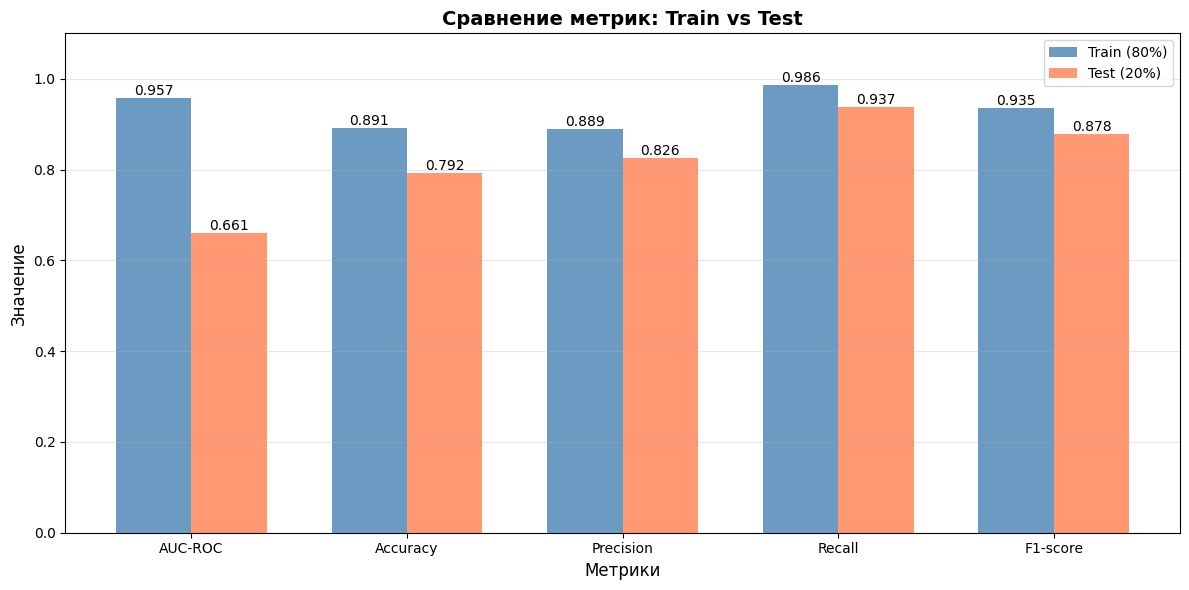

In [82]:

metrics_names = ['AUC-ROC', 'Accuracy', 'Precision', 'Recall', 'F1-score']

train_scores = [
    roc_auc_score(y_train, proba_train),
    accuracy_score(y_train, y_pred_train),
    precision_score(y_train, y_pred_train, zero_division=0),
    recall_score(y_train, y_pred_train, zero_division=0),
    f1_score(y_train, y_pred_train, zero_division=0)
]

test_scores = [
    roc_auc_score(y_test, proba),
    accuracy_score(y_test, y_pred),
    precision_score(y_test, y_pred, zero_division=0),
    recall_score(y_test, y_pred, zero_division=0),
    f1_score(y_test, y_pred, zero_division=0)
]

# Создаем график
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, train_scores, width, label='Train (80%)', color='steelblue', alpha=0.8)
bars2 = ax.bar(x + width/2, test_scores, width, label='Test (20%)', color='coral', alpha=0.8)

# Добавляем значения на столбцы
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

ax.set_xlabel('Метрики', fontsize=12)
ax.set_ylabel('Значение', fontsize=12)
ax.set_title('Сравнение метрик: Train vs Test', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()

# Проверка на overfitting
differences = [abs(t - te) for t, te in zip(train_scores, test_scores)]
max_diff = max(differences)


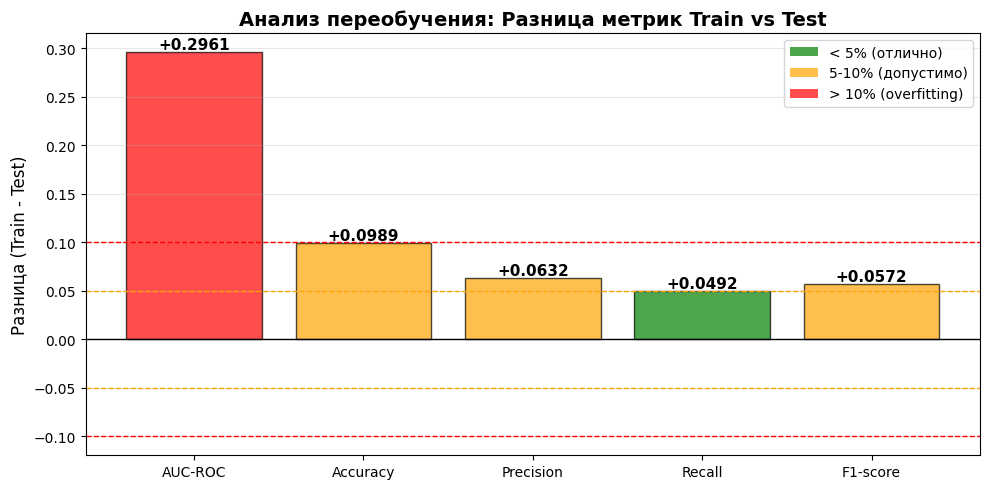


💡 Интерпретация:
   Зеленый: < 5% → Нет переобучения ✅
   Оранжевый: 5-10% → Небольшое переобучение ⚠️
   Красный: > 10% → Сильное переобучение ❌


In [83]:
# График разницы Train - Test (для визуализации переобучения)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

differences = [t - te for t, te in zip(train_scores, test_scores)]
colors = ['green' if abs(d) < 0.05 else 'orange' if abs(d) < 0.10 else 'red' for d in differences]

bars = ax.bar(metrics_names, differences, color=colors, alpha=0.7, edgecolor='black')

# Добавляем значения на столбцы
for bar, diff in zip(bars, differences):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{diff:+.4f}',
            ha='center', va='bottom' if height > 0 else 'top', fontsize=11, fontweight='bold')

# Добавляем пороговые линии
ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
ax.axhline(y=0.05, color='orange', linestyle='--', linewidth=1, label='Порог 5%')
ax.axhline(y=-0.05, color='orange', linestyle='--', linewidth=1)
ax.axhline(y=0.10, color='red', linestyle='--', linewidth=1, label='Порог 10%')
ax.axhline(y=-0.10, color='red', linestyle='--', linewidth=1)

ax.set_ylabel('Разница (Train - Test)', fontsize=12)
ax.set_title('Анализ переобучения: Разница метрик Train vs Test', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# Цветовая легенда
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='green', alpha=0.7, label='< 5% (отлично)'),
    Patch(facecolor='orange', alpha=0.7, label='5-10% (допустимо)'),
    Patch(facecolor='red', alpha=0.7, label='> 10% (overfitting)')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print("\n💡 Интерпретация:")
print("   Зеленый: < 5% → Нет переобучения ✅")
print("   Оранжевый: 5-10% → Небольшое переобучение ⚠️")
print("   Красный: > 10% → Сильное переобучение ❌")


Оценка тестовых данных:

In [ ]:
test_treatment = test_df[test_df['treatment'] == 1].copy()
X_test = test_treatment[FEATURE_COLS]
y_test = test_treatment[TARGET_COL]

proba = predict_click_proba(model, test_treatment)
y_pred = (proba > 0.5).astype(int)


print("Метрики тестовых данных: \n")

print(f"AUC-ROC:   {roc_auc_score(y_test, proba):.4f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred, zero_division=0):.4f}")
print(f"F1-score:  {f1_score(y_test, y_pred, zero_division=0):.4f}")

Метрики тестовых данных: 

AUC-ROC:   0.6609
Accuracy:  0.7917
Precision: 0.8256
Recall:    0.9369
F1-score:  0.8777


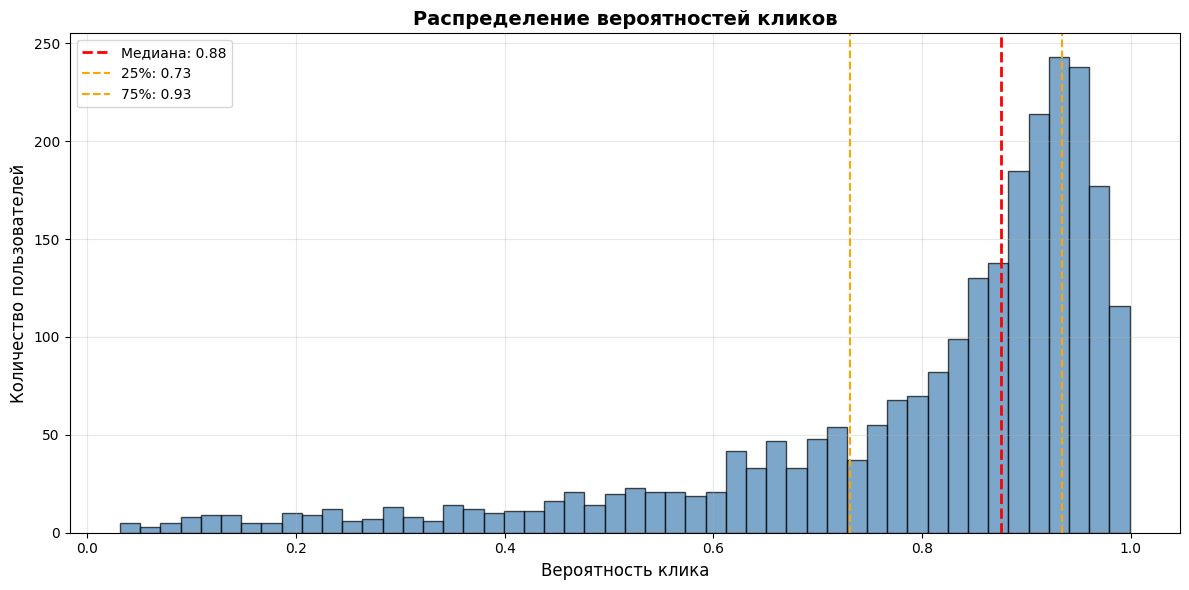

In [85]:
# График: Гистограмма вероятностей
fig, ax1 = plt.subplots(1, 1, figsize=(12, 6))

ax1.hist(proba, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax1.axvline(proba.median(), color='red', linestyle='--', linewidth=2, label=f'Медиана: {proba.median():.2f}')
ax1.axvline(proba.quantile(0.25), color='orange', linestyle='--', linewidth=1.5, label=f'25%: {proba.quantile(0.25):.2f}')
ax1.axvline(proba.quantile(0.75), color='orange', linestyle='--', linewidth=1.5, label=f'75%: {proba.quantile(0.75):.2f}')
ax1.set_xlabel('Вероятность клика', fontsize=12)
ax1.set_ylabel('Количество пользователей', fontsize=12)
ax1.set_title('Распределение вероятностей кликов', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Анализируем вероятности кликов для пользователей из тестовой выборки (20%)

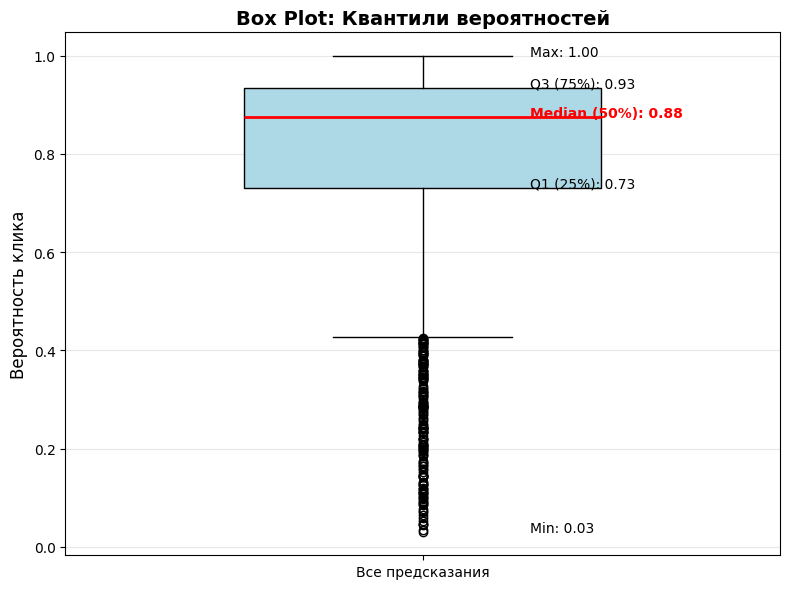

In [86]:
# График: Box Plot с квантилями
fig, ax2 = plt.subplots(1, 1, figsize=(8, 6))

box_data = [proba]
bp = ax2.boxplot(box_data, vert=True, patch_artist=True, widths=0.5)

# Стилизация
bp['boxes'][0].set_facecolor('lightblue')
bp['boxes'][0].set_edgecolor('black')
bp['medians'][0].set_color('red')
bp['medians'][0].set_linewidth(2)

# Аннотации
ax2.text(1.15, proba.min(), f'Min: {proba.min():.2f}', fontsize=10)
ax2.text(1.15, proba.quantile(0.25), f'Q1 (25%): {proba.quantile(0.25):.2f}', fontsize=10)
ax2.text(1.15, proba.median(), f'Median (50%): {proba.median():.2f}', fontsize=10, color='red', fontweight='bold')
ax2.text(1.15, proba.quantile(0.75), f'Q3 (75%): {proba.quantile(0.75):.2f}', fontsize=10)
ax2.text(1.15, proba.max(), f'Max: {proba.max():.2f}', fontsize=10)

ax2.set_ylabel('Вероятность клика', fontsize=12)
ax2.set_title('Box Plot: Квантили вероятностей', fontsize=14, fontweight='bold')
ax2.set_xticklabels(['Все предсказания'])
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


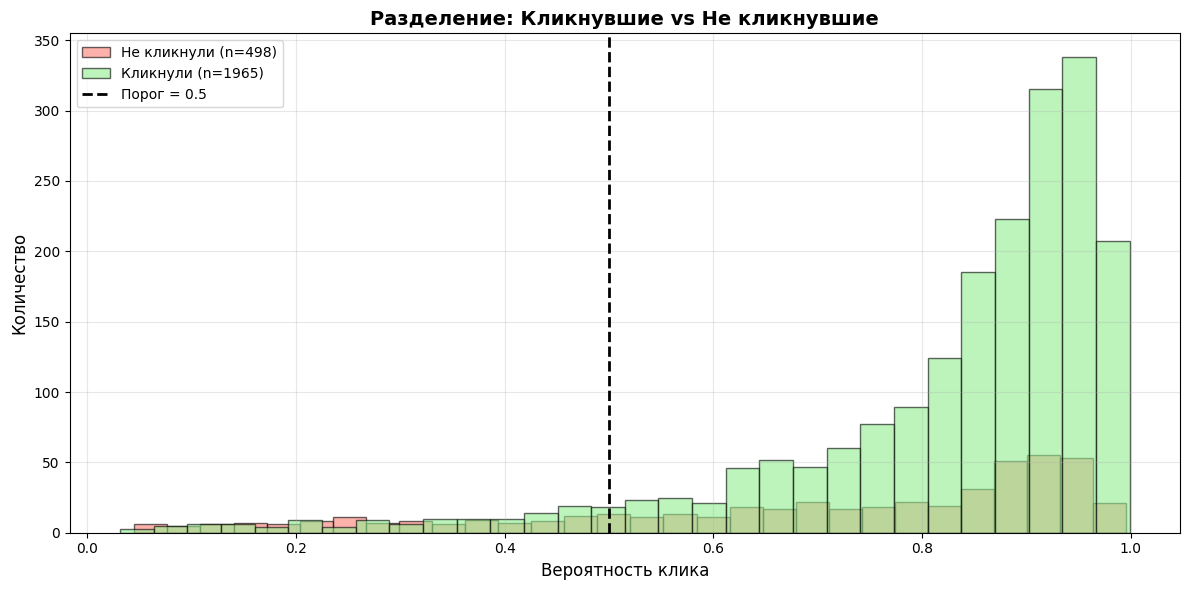

Анализ разделения:
  Кликнули: 1965 (79.8%)
  Не кликнули: 498 (20.2%)

  Средняя вероятность для кликнувших: 0.8261
  Средняя вероятность для не кликнувших: 0.6963


In [87]:
# График: Кликнувшие vs Не кликнувшие
clicked = proba[y_test == 1]
not_clicked = proba[y_test == 0]

fig, ax3 = plt.subplots(1, 1, figsize=(12, 6))

ax3.hist(not_clicked, bins=30, alpha=0.6, label=f'Не кликнули (n={len(not_clicked)})', color='salmon', edgecolor='black')
ax3.hist(clicked, bins=30, alpha=0.6, label=f'Кликнули (n={len(clicked)})', color='lightgreen', edgecolor='black')
ax3.axvline(0.5, color='black', linestyle='--', linewidth=2, label='Порог = 0.5')
ax3.set_xlabel('Вероятность клика', fontsize=12)
ax3.set_ylabel('Количество', fontsize=12)
ax3.set_title('Разделение: Кликнувшие vs Не кликнувшие', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Анализ разделения:")
print(f"  Кликнули: {len(clicked)} ({len(clicked)/len(proba)*100:.1f}%)")
print(f"  Не кликнули: {len(not_clicked)} ({len(not_clicked)/len(proba)*100:.1f}%)")
print(f"\n  Средняя вероятность для кликнувших: {clicked.mean():.4f}")
print(f"  Средняя вероятность для не кликнувших: {not_clicked.mean():.4f}")


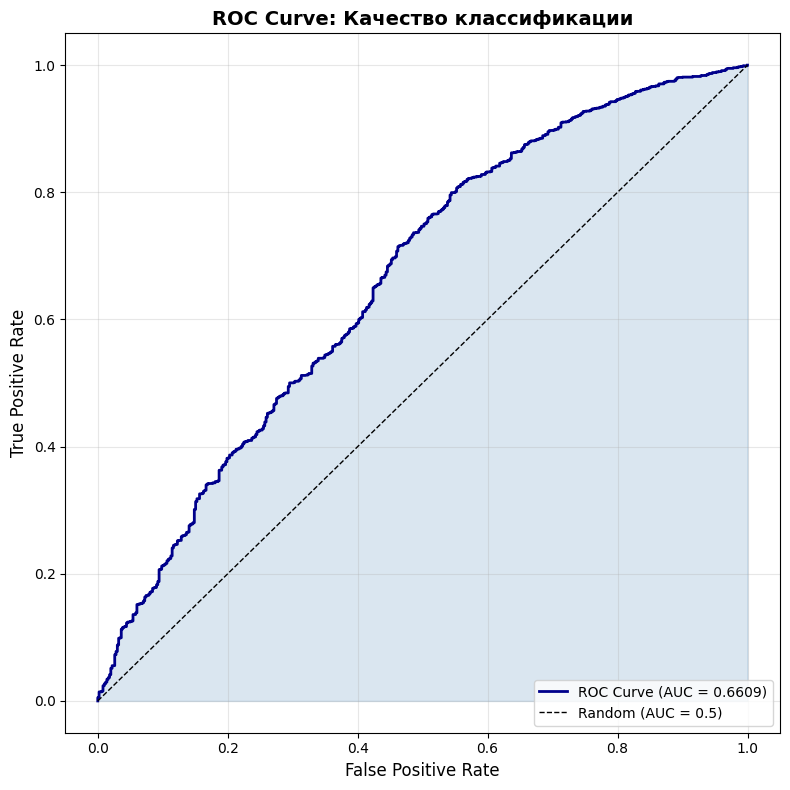

In [88]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, proba)
auc = roc_auc_score(y_test, proba)

fig, ax4 = plt.subplots(1, 1, figsize=(8, 8))

ax4.plot(fpr, tpr, linewidth=2, label=f'ROC Curve (AUC = {auc:.4f})', color='darkblue')
ax4.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random (AUC = 0.5)')
ax4.fill_between(fpr, tpr, alpha=0.2, color='steelblue')
ax4.set_xlabel('False Positive Rate', fontsize=12)
ax4.set_ylabel('True Positive Rate', fontsize=12)
ax4.set_title('ROC Curve: Качество классификации', fontsize=14, fontweight='bold')
ax4.legend(loc='lower right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
print("20 примеров предсказаний на TEST данных:\n")

print(f"{'P(click)':<10} {'Факт':<6} {'User ID':<10} {'Offer':<8} {'Recency':<10} {'Frequency 30d'}")


sample_indices = test_treatment.head(20).index
for idx in sample_indices:
    prob = proba[idx]
    actual = y_test[idx]
    user_id = test_treatment.loc[idx, 'user_id']
    offer_id = test_treatment.loc[idx, 'offer_id']
    recency = test_treatment.loc[idx, 'recency_days']
    freq = test_treatment.loc[idx, 'frequency_30d']
    
    # Эмодзи для наглядности
    emoji = "✅" if (prob > 0.5 and actual == 1) or (prob <= 0.5 and actual == 0) else "❌"
    
    print(f"{prob:>6.1%}     {actual:<6} {user_id:<10} {offer_id:<8} {recency:<10.0f} {freq:<15.0f} {emoji}")

print("\n✅ - правильное предсказание, ❌ - ошибка")

correct = ((proba > 0.5).astype(int) == y_test).sum()
total = len(y_test)
print(f"\nВсего правильных предсказаний: {correct}/{total} ({correct/total*100:.1f}%)")


20 примеров предсказаний на TEST данных:

P(click)   Факт   User ID    Offer    Recency    Frequency 30d
 99.7%     1      16210      2        1          42              ✅
 67.9%     0      13121      0        268        0               ❌
 78.9%     1      15831      0        57         0               ✅
 99.1%     1      17097      0        1          84              ✅
 86.6%     1      17235      0        24         19              ✅
 81.2%     1      17027      2        78         0               ✅
 63.2%     0      14340      0        218        0               ❌
 67.5%     1      13976      0        206        0               ✅
 47.1%     1      17102      0        261        0               ❌
 84.4%     1      16119      2        7          5               ✅
 89.2%     1      14540      2        9          15              ✅
 85.0%     1      16460      0        27         17              ✅
 91.9%     0      15208      0        0          9               ❌
 93.8%     1      13741 